In [3]:
import tensorflow as tf
from object_detection.utils import dataset_util
import pandas as pd
import numpy as np
import seaborn as sns
import os
import io
import matplotlib.pyplot as plt
from object_detection.dataset_tools import tf_record_creation_util
from sklearn.model_selection import train_test_split

In [4]:
DATA_PATH = '../RPN_Backbone_GZ2/Data/'
IMAGE_PATH = DATA_PATH + 'real_pngs/'
TFRECORDS_PATH = './Data/tf_records/'

# using typical split of 80:10:10
SIZE_OF_VALIDATION_SET = 0.2
SIZE_OF_TEST_SET = 0.1

In [5]:
# loading metadata
file_path1 = DATA_PATH + 'combined_cat.pkl'
file_path2 = DATA_PATH + 'zoo2LocalIdMap.pkl'

df_combined_cat = (pd
    .read_pickle(file_path1)
    #.reset_index() 
    #.explode('false_pos_prob_stats')
)

zooToLocal = pd.read_pickle(file_path2)
df_combined_cat['local_ids'] = zooToLocal.loc[df_combined_cat.index.get_level_values(0)].to_numpy()

df_combined_cat.reset_index(inplace=True)

# Filter out any bulge markings that snuck through
is_central = (
    np.abs(0.5*(df_combined_cat['x2_normed'] + df_combined_cat['x1_normed']) - 0.5) < 0.02
    ) & (
    np.abs(0.5*(df_combined_cat['y2_normed'] + df_combined_cat['y1_normed']) - 0.5) < 0.02
    )

df_combined_cat = df_combined_cat.loc[~is_central | df_combined_cat['empty']].copy()

# reduce to only samples with objects
df_combined_cat = df_combined_cat[~df_combined_cat['empty']]


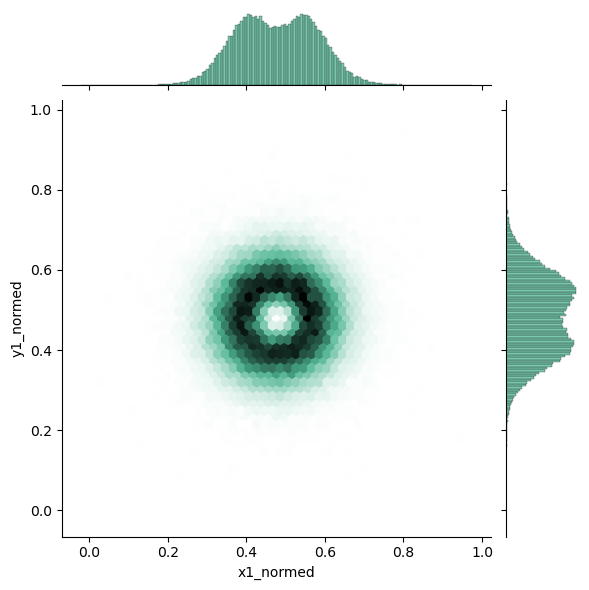

In [6]:
sns.jointplot(
    x=df_combined_cat['x1_normed'],
    y=df_combined_cat['y1_normed'],
    kind='hex', 
    color='#4CB391'
)

In [7]:
x_bounds_normed = np.array([df_combined_cat['x1_normed'].quantile(0.01), df_combined_cat['x2_normed'].quantile(0.99)])
y_bounds_normed = np.array([df_combined_cat['y1_normed'].quantile(0.01), df_combined_cat['y2_normed'].quantile(0.99)])
print(f'x_bounds = {np.rint(x_bounds_normed * 400)}', f'y_bounds = {np.rint(y_bounds_normed * 400)}')

x_bounds = [100. 301.] y_bounds = [104. 302.]


In [8]:
# cutout = np.array([95, 305, 95, 305])
# cutout_normed = np.array([95, 305, 95, 305])/400

# stick to sizes used for Zoobot training
cutout = np.array([50, 350, 50, 350])
cutout_normed = np.array([50, 350, 50, 350])/400
cutout_normed

array([0.125, 0.875, 0.125, 0.875])

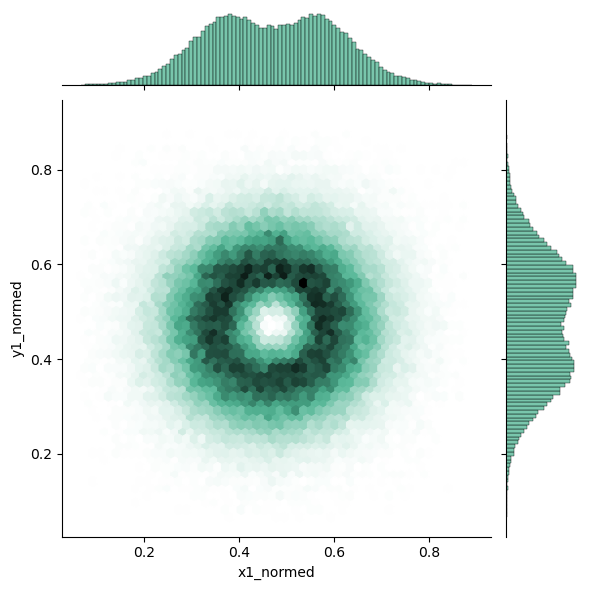

In [9]:
pad = 0.05
selector = (
    df_combined_cat['x1_normed'] > cutout_normed[0] + pad
    ) & (
    df_combined_cat['x2_normed'] < cutout_normed[1] - pad
    ) & (
    df_combined_cat['y1_normed'] > cutout_normed[2] + pad
    ) & (
    df_combined_cat['y2_normed'] < cutout_normed[3] - pad
    )

df_combined_cat = df_combined_cat[selector | df_combined_cat['empty']].copy()

def convert_x_normed(x_normed):
    x_normed = (x_normed - cutout_normed[0]) / (cutout_normed[1] - cutout_normed[0])
    return x_normed

def convert_y_normed(y_normed):
    y_normed = (y_normed - cutout_normed[2]) / (cutout_normed[3] - cutout_normed[2])
    return y_normed

df_combined_cat['x1_normed'] = df_combined_cat.apply(lambda x: convert_x_normed(x['x1_normed']), axis=1)
df_combined_cat['x2_normed'] = df_combined_cat.apply(lambda x: convert_x_normed(x['x2_normed']), axis=1)

df_combined_cat['y1_normed'] = df_combined_cat.apply(lambda y: convert_y_normed(y['y1_normed']), axis=1)
df_combined_cat['y2_normed'] = df_combined_cat.apply(lambda y: convert_y_normed(y['y2_normed']), axis=1)

sns.jointplot(
    x=df_combined_cat['x1_normed'],
    y=df_combined_cat['y1_normed'],
    kind='hex', 
    color='#4CB391'
)

In [10]:
image_id = 36735225
df_combined_cat[df_combined_cat['image_id'] == image_id].head()

,image_id,association,x1,x2,y1,y2,x1_normed,x2_normed,y1_normed,y2_normed,...,multiplicity,false_pos_prob_stats,false_pos_prob,inaccurate_prob,risk,empty,batch,finish_criterion,image_multiplicity,local_ids
31770,36735225,30,116.057632,129.277269,202.362300,215.581936,0.220192,0.264258,0.507874,0.551940,...,9,"[9.0, 0.3836375947524945, 0.21023637655797806,...",0.638066,0.001148,0.639629,False,99,completion_assessor,20,100630278205
31771,36735225,77,263.231037,276.450673,150.479214,163.698851,0.710770,0.754836,0.334931,0.378996,...,16,"[16.0, 0.3546928557944703, 0.2080345851277972,...",0.000038,0.000010,0.000059,False,99,completion_assessor,20,100630278205
31772,36735225,92,169.976759,183.196395,220.724915,233.944552,0.399923,0.443988,0.569083,0.613149,...,16,"[16.0, 0.35397671481270754, 0.2087675498690813...",0.000013,0.000011,0.000034,False,99,completion_assessor,20,100630278205
31773,36735225,93,260.984525,274.204162,201.638464,214.858101,0.703282,0.747347,0.505462,0.549527,...,17,"[17.0, 0.3721165060562909, 0.21553139263011425...",0.000045,0.000012,0.000069,False,99,completion_assessor,20,100630278205
31774,36735225,94,239.557773,252.777409,222.816545,236.036181,0.631859,0.675925,0.576055,0.620121,...,2,"[2.0, 0.1463400360705488, 0.05088336537498807,...",0.980876,0.074129,1.056423,False,99,completion_assessor,20,100630278205


<AxesSubplot: xlabel='x2_normed', ylabel='y1_normed'>

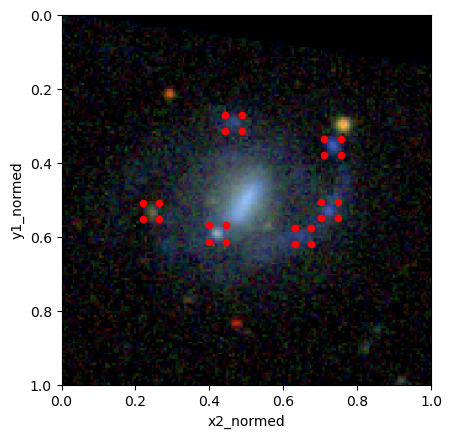

In [11]:
image_file = IMAGE_PATH + str(df_combined_cat.loc[df_combined_cat['image_id'] == image_id, 'local_ids'].iloc[0]) + '.png'
image = plt.imread(image_file)[cutout[0]:cutout[1],cutout[2]:cutout[3]]
plt.imshow(image, extent=[0,1,1,0]) # note origin upper 

df_combined_cat[df_combined_cat['image_id'] == image_id].plot.scatter('x1_normed', 'y1_normed', ax=plt.gca(), c='r')
df_combined_cat[df_combined_cat['image_id'] == image_id].plot.scatter('x2_normed', 'y2_normed', ax=plt.gca(), c='r')
df_combined_cat[df_combined_cat['image_id'] == image_id].plot.scatter('x1_normed', 'y2_normed', ax=plt.gca(), c='r')
df_combined_cat[df_combined_cat['image_id'] == image_id].plot.scatter('x2_normed', 'y1_normed', ax=plt.gca(), c='r')

In [12]:
df_combined_cat['filename'] = IMAGE_PATH + df_combined_cat['local_ids'].apply(str) + '.png'
df_combined_cat['file_exists'] = (df_combined_cat['filename']).apply(os.path.exists)

In [13]:
# labels
# 0 - background
# 1 - Clump 
# 2 - Odd Clump
# 3 - Improbable Clump
# 4 - Odd Improbable Clump
df_combined_cat['is_odd'] = np.where(df_combined_cat['mean_tool'] > 0.5, True, False)
df_combined_cat['is_improbable'] = np.where(df_combined_cat['false_pos_prob'] > 0.7, True, False)

df_combined_cat['label'] = np.select(
    [
        (~df_combined_cat['empty']) & (~df_combined_cat['is_odd']) & (~df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (df_combined_cat['is_odd']) & (~df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (~df_combined_cat['is_odd']) & (df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (df_combined_cat['is_odd']) & (df_combined_cat['is_improbable']),
    ], 
    [
        1,
        2,
        2, #3
        2, #4
    ],
    default = None
)

df_combined_cat['label_text'] = np.select(
    [
        (~df_combined_cat['empty']) & (~df_combined_cat['is_odd']) & (~df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (df_combined_cat['is_odd']) & (~df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (~df_combined_cat['is_odd']) & (df_combined_cat['is_improbable']),
        (~df_combined_cat['empty']) & (df_combined_cat['is_odd']) & (df_combined_cat['is_improbable']),
    ], 
    [
        b'clumpy',
        b'clumpy, odd',
        b'clumpy, odd', # b'clumpy, improbable',
        b'clumpy, odd', # b'clumpy, odd and improbable',
    ],
    default = ''
)

In [14]:
df_combined_cat[(df_combined_cat['empty']) &(df_combined_cat['label'] == 1)].head(50)

,image_id,association,x1,x2,y1,y2,x1_normed,x2_normed,y1_normed,y2_normed,...,batch,finish_criterion,image_multiplicity,local_ids,filename,file_exists,is_odd,is_improbable,label,label_text


In [33]:
def create_tf_example(image_file_path, local_id, image_id, x1_normed, x2_normed, y1_normed, y2_normed, image_label_text, image_label):
    if not os.path.exists(image_file_path):
        print(f"WARNING! {image_file_path} not found!")
        return None

    height = cutout[3] - cutout[2] # Image height
    width = cutout[1] - cutout[0] # Image width
    encoded_image_data = tf.io.read_file(image_file_path) # Encoded image bytes
    image_tensor_uint8 = tf.image.decode_png(encoded_image_data)
    clipped_image_data = tf.image.encode_png(image_tensor_uint8[cutout[0]:cutout[1], cutout[2]:cutout[3]])
    encoded_image_data = clipped_image_data.numpy()
    image_format = b"PNG" # b'jpeg' or b'png'

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/local_id': dataset_util.int64_feature(local_id),
        # 'image/source_id': dataset_util.int64_feature(image_id),
        'image/source_id': dataset_util.bytes_feature(image_id.encode('utf-8')),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(x1_normed),
        'image/object/bbox/xmax': dataset_util.float_list_feature(x2_normed),
        'image/object/bbox/ymin': dataset_util.float_list_feature(y1_normed),
        'image/object/bbox/ymax': dataset_util.float_list_feature(y2_normed),
        'image/object/class/text': dataset_util.bytes_list_feature(image_label_text),
        'image/object/class/label': dataset_util.int64_list_feature(image_label),
    }))
    return tf_example

In [31]:
def write_catalog_to_tfrecord_shards(df, tf_record_file_name, num_shards):
    tf_record_file_path = TFRECORDS_PATH + tf_record_file_name + '.records-{:05d}-of-{:05d}' # e.g. real_pngs.record-00000-of-00042
    dfs = np.array_split(df, num_shards)

    for index, df in enumerate(dfs):
        tf_record_shardfile_path = tf_record_file_path.format(index, num_shards)

        with tf.io.TFRecordWriter(tf_record_shardfile_path) as writer:
            missing = 0
            
            for idx, df_galaxy_data in df.groupby(level='filename'):
                df_temp = df_galaxy_data.reset_index()
                
                image_file_path = os.path.join(df_temp['filename'].iloc[0])
                local_id = df_temp['local_ids'].iloc[0]
                image_id = str(df_temp['image_id'].iloc[0])
                x1_normed = df_temp['x1_normed']
                x2_normed = df_temp['x2_normed']
                y1_normed = df_temp['y1_normed']
                y2_normed = df_temp['y2_normed']
                image_label_text = df_temp['label_text']
                image_label = df_temp['label']

                tf_example = create_tf_example(image_file_path, local_id, image_id, x1_normed, x2_normed, y1_normed, y2_normed, image_label_text, image_label)
                
                if tf_example is not None:
                    writer.write(tf_example.SerializeToString())
                else:
                    print("missing")
                    missing += 1

In [17]:
# get train and validation samples
unique_ids = df_combined_cat[df_combined_cat['file_exists']]['image_id'].unique()

In [18]:
train_ids, val_ids = train_test_split(unique_ids, test_size=SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET, random_state=42)

In [19]:
df_combined_cat = df_combined_cat[df_combined_cat['file_exists']]

In [20]:
df_combined_cat = df_combined_cat[
    ['image_id', 'local_ids', 'filename', 'label', 'label_text',
    'x1_normed', 'x2_normed', 'y1_normed', 'y2_normed']
]

In [21]:
imageGroups_train = df_combined_cat[df_combined_cat['image_id'].isin(train_ids)]
imageGroups_valid = df_combined_cat[df_combined_cat['image_id'].isin(val_ids)]

imageGroups_train = imageGroups_train.set_index(['image_id', 'local_ids', 'filename', 'label'])
imageGroups_valid = imageGroups_valid.set_index(['image_id', 'local_ids', 'filename', 'label'])

In [22]:
batch_size = 8
epochs = 80
print('Size of train-set: {}, Size of validation-set: {}'.format(len(train_ids),len(val_ids)))
print('So, for {} epochs we need {} steps.'.format(epochs, (len(train_ids)+len(val_ids)/batch_size*epochs)))

Size of train-set: 13939, Size of validation-set: 5975
So, for 80 epochs we need 73689.0 steps.


In [ ]:
# shard size of 3000 should lead to roughly 150MB files
shard_size = 3000
# write_catalog_to_tfrecord_shards(df, 'GZ2_ClumpScout', (len(df) // shard_size) + 1)
write_catalog_to_tfrecord_shards(imageGroups_train, 'GZ2_ClumpScout_train', (len(train_ids) // shard_size) + 1)
write_catalog_to_tfrecord_shards(imageGroups_valid, 'GZ2_ClumpScout_val', (len(val_ids) // shard_size) + 1)

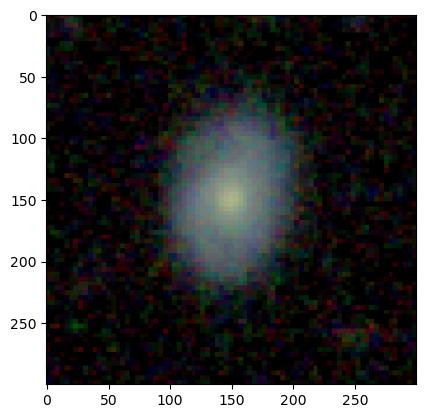

In [50]:
# check TFRecords
import pathlib
test_set =  sorted(str(p) for p in pathlib.Path(TFRECORDS_PATH).glob('GZ2_ClumpScout_val.records*'))

test_image_dataset = tf.data.TFRecordDataset(test_set)

# Create a dictionary describing the features.
test_image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/local_id': tf.io.FixedLenFeature([], tf.int64),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    'image/object/class/label': tf.io.VarLenFeature(tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, test_image_feature_description)

parsed_image_dataset = test_image_dataset.map(_parse_image_function)

for image_features in parsed_image_dataset.take(4):
    image_raw = tf.image.decode_image(image_features['image/encoded']).numpy()
    plt.imshow(image_raw)


[2, 1]
[b'clumpy, odd', b'clumpy']


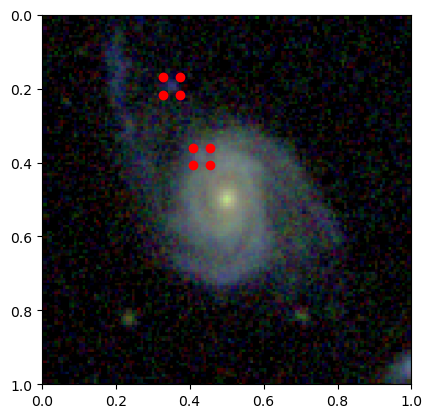

In [51]:
# check TFRecords
test_image_dataset = tf.data.TFRecordDataset('./Data/tf_records/GZ2_ClumpScout_train.records-00001-of-00011')

img_example = next(iter(test_image_dataset)) 

img_parsed = tf.train.Example.FromString(img_example.numpy())

img_encoded = img_parsed.features.feature['image/encoded'].bytes_list.value[0]
image = tf.image.decode_image(img_encoded).numpy()
xmin = img_parsed.features.feature['image/object/bbox/xmin'].float_list.value[:]
xmax = img_parsed.features.feature['image/object/bbox/xmax'].float_list.value[:]
ymin = img_parsed.features.feature['image/object/bbox/ymin'].float_list.value[:]
ymax = img_parsed.features.feature['image/object/bbox/ymax'].float_list.value[:]
label = img_parsed.features.feature['image/object/class/label'].int64_list.value[:]
label_text = img_parsed.features.feature['image/object/class/text'].bytes_list.value[:]

plt.imshow(image, extent=[0,1,1,0])
plt.scatter(xmin, ymin, c='r')
plt.scatter(xmax, ymax, c='r')
plt.scatter(xmin, ymax, c='r')
plt.scatter(xmax, ymin, c='r')

print(str(label))
print(label_text)

[1, 1, 1]
[b'Clump', b'Clump', b'Clump']


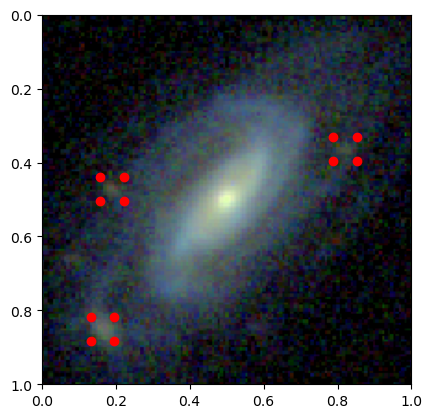

In [52]:
# check TFRecords
test_image_dataset = tf.data.TFRecordDataset('./Data/tf_records_hugh/real_pngs.record-00000-of-00042')

img_example = next(iter(test_image_dataset)) 

img_parsed = tf.train.Example.FromString(img_example.numpy())

img_encoded = img_parsed.features.feature['image/encoded'].bytes_list.value[0]
image = tf.image.decode_image(img_encoded).numpy()
xmin = img_parsed.features.feature['image/object/bbox/xmin'].float_list.value[:]
xmax = img_parsed.features.feature['image/object/bbox/xmax'].float_list.value[:]
ymin = img_parsed.features.feature['image/object/bbox/ymin'].float_list.value[:]
ymax = img_parsed.features.feature['image/object/bbox/ymax'].float_list.value[:]
label = img_parsed.features.feature['image/object/class/label'].int64_list.value[:]
label_text = img_parsed.features.feature['image/object/class/text'].bytes_list.value[:]

plt.imshow(image, extent=[0,1,1,0])
plt.scatter(xmin, ymin, c='r')
plt.scatter(xmax, ymax, c='r')
plt.scatter(xmin, ymax, c='r')
plt.scatter(xmax, ymin, c='r')

print(str(label))
print(label_text)